In [1]:
# Call the only package needed to run the examples
# (all other imports occur when my_1D_and_2D_Poisson_FEM_script.py
# is called below)
from matplotlib import pyplot as plt
%matplotlib inline

# Individual Homework 2

## Jordan Hall

## Math 8660

## Problem 1

#### 1. This is primarily a coding problem that focuses on understanding the assembly of the $A\mathbf{U}=\mathbf{F}$ problem. Consider the Poisson problem on $\Omega=(0,1)\subset\mathbb{R}$ and $\Omega=(0,1)^2=(0,1)\times(0,1)\subset\mathbb{R}^2$. Suppose we numerically solve the Poisson problem with homogeneous Dirichlet boundary conditions using a standard FEM with piecewise linear elements.

 (a.) For regular uniform meshes on both the 1D and 2D problems, construct a function to compute the $ij$-components of the matrix $A$ on page 12  of the lecture 01A notes using numpy arrays where the only input is a list with the number of elements in each dimension (the function should determine what the dimension is by the number of items in the list) and the output is the matrix $A$ assuming the triangular elements in 2D have the diagonal going from the bottom left to the upper right of the regular grid of nodes. Check your results with FEniCS.  Note that while you should assume a natural serpentine ordering/numbering to the elements that FEniCS likely uses a different ordering to the elements, so your check will have to acknowledge this if it is the case. You should show your derivations of the $ij$-components of $A$. 
    

    
(b.) Similar to the above part, construct an integrating function that takes a user-defined function and the list of the number of elements (in 1D or 2D) to construct/assemble the $\mathbf{F}$ vector discussed on page 12 of the lecture 01A notes. The user-defined function should also have a keyword that specifies the quadrature degree that should be used when integrating it (so degree=1 should mean that integrating this function against piecewise linears is done exactly if the user-defined function is in fact linear itself, degree=2 should mean integrating this function against piecewise linears is done exactly if the user-defined function is in fact quadratic itself, and so on). This attribute of the user-defined function should be used by the integrating function to determine which quadrature rule to use. If you can find/figure out how to use a pre-packaged quadrature library/module, then that is fine (and in fact encouraged). Compare your results with FEniCS. 
Hint: the user-defined function should be an instance of a class. See the notebook that was posted with this assignment for an example.

## Solution.

### Analysis.

We begin by showing the mathematical derivations used to determine $A$ and $\mathbf{F}$. The derivations preseneted here were used to develop the numerical implementations presented below. I worked closely with Vince and Daniel on the analysis here, but everyone of course is writing things up seperately. I also note that I worked closely with Vince and Daniel on the coding, but also asked Wenjuan and Lauren questions to see how they did a few things. I will make note of specific contributions in any case where they were significant/unique to the person.

#### 1D Case (Analysis)

We begin with the problem $-\Delta u(x)=f(x), x\in \Omega=(0,1)$, with boundary conditions $u(0)=u(1)=0$. Let $V=H_0^1(\Omega)$. We know (see the notes) that the weak form of this prolem is the task of finding $u_h \in V_h$ such that $$(\nabla u_h, \nabla v_h)_{L^2(\Omega)}=(f,v_h)_{L^2(\Omega)} \quad \forall v_h\in V_h,$$

where we consider $V_h=\{v \in V: v \in \mathcal{P}^1(K) \quad \forall K \in \tau_h\},$ a space of piecewise linear interpolants. Here $K$ denotes a particular element (read: interval in 1D) given by the mesh $\tau_h$ where $h=1/n,$ $n=2,3,4,\ldots$ is the mesh size/discretization level.

Since $V_h$ is finite dimensional, we know it has a basis $\{\phi_i, i=1,\ldots,N\}$ with $\sum_{i=1}^N \phi_i(x)=1$ $\forall x \in \Omega$. Since any $v_h \in V_h$ is a linear combination of the $\phi_i$'s it is enough to solve for $u_h \in V_h$ such that $$(\nabla u_h, \nabla \phi_i)_{L^2(\Omega)}=(f,\phi_i)_{L^2(\Omega)} \quad i=1,\ldots,N, \quad u_h(0)=u_h(1)=0.$$

We can use the same idea to realize $u_h$ is also just a linear combiation of $\phi_i$'s. Say $$u_h=U_1\phi_1 + \ldots + U_N\phi_N.$$ Letting $\mathbf{U}:=[U_1 \ldots U_N]^\top$, a little linear algebra leads us to writing

$$A \mathbf{U}=\mathbf{F},$$

$$A_{i,j}=(\nabla \phi_i, \nabla \phi_j)_L^2(\Omega),$$

$$\mathbf{F}_i = (f, \phi_i)_L^2(\Omega).$$

In other words, we see that the task of solving our variational form over $V_h$ is equivalent to the task of recovering the coefficients stored in $\mathbf{U}$ by solving the linear algebra problem above.

For a fixed $h$, $A$ is completely fixed/predetermined in this setting -- in other words, givin the same discretization, $A$ will remain the same no matter which forcing $f$ is specificed. As such, we can actually write down $A_{i,j}$ for a fixed $h=1/n$. 

$\mathbf{F}$, on the other hand, will not be derived here; it will be approximated numerically. This is of course because the values of $\mathbf{F}$ matter very much on the choice of forcing.

Given $h=1/n$, since $\sum_{i=1}^N \phi_i(x)=1$ and each $\phi_i$ is linear, drawing a few pictures, we find

$\nabla \phi_i(x)=\left\lbrace
    \begin{array}{ll}
         n & \text{if }\; (i-1)h \le x < ih \\
        -n & \text{if }\; ih \le x < (i+1)h \\
        0           & \text{otherwise.}
    \end{array}
\right. \quad\quad\quad\quad i=1,\cdots,N. $

Drawing a few more pictures, one will find that determining $A$ boils down to determining $(\nabla \phi_i(x),\nabla \phi_i(x))_{L^2(\Omega)}$ for the same $i=1,\ldots,N$, $(\nabla \phi_i(x),\nabla \phi_{i+1}(x))_{L^2(\Omega)}$ for $i=1,\ldots,N-1$, and $(\nabla \phi_i(x),\nabla \phi_{i-1}(x))_{L^2(\Omega)}$ for $i=2,\ldots,N$.

By symmetry arguments, we find $(\nabla \phi_1(x),\nabla \phi_1(x))_{L^2(\Omega)}=\cdots=(\nabla \phi_N(x),\nabla \phi_N(x))_{L^2(\Omega)}$. Thus, we must only compute $(\nabla \phi_i(x),\nabla \phi_i(x))_{L^2(\Omega)}$ once for a general $i$.

In a similar fashion, we have $(\nabla \phi_i(x),\nabla \phi_{i+1}(x))_{L^2(\Omega)}=(\nabla \phi_i(x),\nabla \phi_{i-1}(x))_{L^2(\Omega)}$ so that we must only compute (WLOG) $(\nabla \phi_i(x),\nabla \phi_{i+1}(x))_{L^2(\Omega)}$. 

Otherwise, because of the supports of the basis elements, the $L^2$ inner product between $\nabla \phi_i$ and $\nabla \phi_j$ will be zero anytime $|i-j|>1$.

We begin by computing the diagonal elements of $A$, $A_{i,i}$, $i=1,\ldots,N$.

$$A_{i,i}=(\nabla \phi_i(x),\nabla \phi_i(x))_{L^2(\Omega)}=\int_0^{2h} n^2 dx=2hn^2=2n,$$

where the last equality comes from recalling that $h=1/n$.

If $|i-j|=1$, $i,j=1,\ldots,N,$ we compute $A_{i,j}$

$$A_{i,j}=(\nabla \phi_i(x),\nabla \phi_j(x))_{L^2(\Omega)}=\int_0^h -n^2 dx=-hn^2=-n.$$

We again note that due to the fact that $\nabla \phi_i$ and $\nabla \phi_j$ do not share support for $|i-j|>2,$ so $$A_{i,j}=0$$ for all $i,j=1,\ldots,N$ such that $|i-j|>2.$

We have now written the equations needed to define $A$ for any choice $h$ in the 1D Poisson problem with Dirichlet boundaries. Recall that computing $\mathbf{F}$ is a numerical problem we will address below.

#### 2D Case (Analysis)

Now we have the problem $-\Delta u(x,y)=f(x,y), x\in \Omega=(0,1)\times(0,1)$, with boundary conditions $u(x,y)=0$ if $x=0$, $x=1$, $y=0$, or $y=1$. Let $V=H_0^1(\Omega)$.

Almost all of the set-up from above will be identical here, with the noteable detail that $V_h$ is now a space of two-variable piecewise linear interpolants, or "pyramids."

We solve the same system

$$A \mathbf{U}=\mathbf{F},$$

$$A_{i,j}=(\nabla \phi_i, \nabla \phi_j)_L^2(\Omega),$$

$$\mathbf{F}_i = (f, \phi_i)_L^2(\Omega),$$

where it's understood that the $\phi_i$'s and $f$ are two variable functions and hence $\nabla \phi_i \in \mathbb{R}^{2\times 1}$.

Once again, for a fixed $h$, $A$ is completely fixed/predetermined in this setting -- in other words, givin the same discretization, $A$ will remain the same no matter which forcing $f$ is specificed. As such, we can actually write down $A_{i,j}$ for a fixed $h=1/n$ and $\mathbf{F}$ is a numerical problem as above.

We begin by assuming that we discretize the same amount in each direction. That is, $h_x=h_y=1/n$. Since $\sum_{i=1}^N \phi_i(x,y)=1$ and each $\phi_i$ is linear, drawing a lot of pictures on a whiteboard, we find that fixing $(x,y)$ in some (right triangle) element $K$, $\nabla \phi_i$ will be one of several possible forms:

$\nabla \phi_i(x,y)= [\pm n \quad \pm n]^\top, \quad [\pm n \quad \mp n]^\top, \quad [0 \quad \pm n]^\top, \quad [\pm n \quad 0]^\top, \quad \quad      i=1,\cdots,N. $

Drawing a few more pictures, one will find that determining $A$ boils down to determining $(\nabla \phi_i(x,y),\nabla \phi_i(x,y))_{L^2(\Omega)}$ for the same $i=1,\ldots,N$ and $(\nabla \phi_i(x,y),\nabla \phi_{j}(x,y))_{L^2(\Omega)}$ for $i,j=1,\ldots,N$ where the supports of $\nabla \phi_i$ and $\nabla \phi_j$ actually have overlap -- when those supports don't overlap, $A_{i,j}=0$. We also notice that we will have some combinations of $\nabla \phi_i$ and $\nabla \phi_j$ which are orthogonal, meaning that those $A_{i,j}$ will also be $0.$

By symmetry arguments, we find $(\nabla \phi_1(x,y),\nabla \phi_1(x,y))_{L^2(\Omega)}=\cdots=(\nabla \phi_N(x,y),\nabla \phi_N(x,y))_{L^2(\Omega)}$. Thus, we must only compute $(\nabla \phi_i(x,y),\nabla \phi_i(x,y))_{L^2(\Omega)}$ once for a general $i$.

In a similar fashion, we will find the nonzero $(\nabla \phi_i(x,y),\nabla \phi_{j}(x,y))_{L^2(\Omega)}$. There are exactly $(n-1)^2$ elements $K$ will non-trivial basis function -- this is due to the Dirichlet boundary conditions which essentially zero out every basis element along the edge of the unit square. Of the $(n-1)^2$ nontrivial basis function, there are always 4 trivial inner products due to the orthogonality of certain of the gradients (above.)

Otherwise, because of the supports of the basis elements or orthogonality of their gradients, the $L^2$ inner product between $\nabla \phi_i$ and $\nabla \phi_j$ will be zero.

We begin by computing the diagonal elements of $A$, $A_{i,i}$, $i=1,\ldots,N$. We note that since we are taking the inner product of $\nabla \phi_i$ with itself, there will be shared support across 6 elements $K$ (since each $\nabla \phi_i$ has exactly 6 elements in its support). On 4 of those elements, one can show that $\nabla \phi_i^\top \nabla \phi_i=n^2$; on the other 2 elements, we have $\nabla \phi_i^\top \nabla \phi_i=2n^2.$ Hence,

$$A_{i,i}=(\nabla \phi_i(x,y),\nabla \phi_i(x,y))_{L^2(\Omega)}=4 \int_0^h \int_0^x n^2 dydx + 2 \int_0^h \int_0^y 2n^2 dxdy$$

$$=4 \int_0^h xn^2 dx +4 \int_0^h yn^2 dy =4.$$

where the last equality comes from recalling that $h=1/n$.

If $i,j=1,\ldots,N,$ are such that $\nabla \phi_i$ and $\nabla \phi_j$ share support and are not orthogonal, one will find that support will be shared on precisely 2 elements. WLOG, on both of those elements, one can show that $\nabla \phi_i^\top \nabla \phi_j=-n^2$. Hence,

$$A_{i,j}=(\nabla \phi_i(x,y),\nabla \phi_j(x,y))_{L^2(\Omega)}=2\int_0^h\int_y^h  -n^2 dxdy=2\int_0^h n^2(y-h)dy=2\left(-1+h^2n^2\frac{1}{2}\right)=-1.$$

We again note that if $\nabla \phi_i$ and $\nabla \phi_j$ do not share support or are orthogonal, we will have $$A_{i,j}=0$$ for all such $i,j=1,\ldots,N$.

We have now written the equations needed to define $A$ for any choice $h$ in the 2D Poisson problem with Dirichlet boundaries, so long as the discretization is equal in the $x$ and $y$ directions. When the discretization is not equal, we find that the elements of $A$ described above are valid, and there will be additional zero-padding only.

Recall that computing $\mathbf{F}$ is a numerical problem we will address below.

I thank Vince and Dan -- I worked closely with both classmates to figure out the 2D case!

### Numerics.

I chose to write a python sript containing the 2 functions asked for in parts (a.)/(b.), along with every import statement needed to define the functions. (Note that I called a single import statement above for plotting purposes, which is really only necessary for de-bugging and showing examples here in this notebook.

The script has been sufficiently commented out, so that it is possible to be read and graded, but also possible for me to continue de-bugging in the short-term and read/re-use in the long-term.

Using a script greatly shortens the length of this notebook, removing the tens of unnecessary cells that I used in earlier development.

Needless to say, one must have the python script saved into the working directory for the below "cell magic" to successfully call my script.

Finally, we note that the function which creates the loading vector $\mathbf{F}$ uses a scipy integrater, which does not require specifying a quadrature degree. Thus, this function will not take in a degree of quadrature as an input at all. I used FEniCS under the hood to define the interpolants, which is something I thank Lauren and Wenjuan for, since they both told me this is how they did things! This was my idea separately, but I went to both Lauren and Wenjuan for a sanity check.

In [2]:
# Use cell magic to call my script
%run JHall_1D_and_2D_Poisson_FEM_script.py

To test the functions which generate $A$ and $\mathbf{F}$ for the 1D problem and 2D problem, we begin by specifying lists containing $h$, the discretization factor, in 1D and $h_x,h_y$, the discretization factors in each direction for 2D. The 1D code is quick, so we define a relatively fine mesh; the 2D code is a little heftier, so we throw it a coarse grid for now.

In [3]:
# For testing, define lists containing
# the number of elements in the x direction
# and y direction (if applicable)
L1D=[10]
L2D=[3,3]

We first print the $A$ matrix corresponding to each problem. Recall that regardless of $f$, $A$ is fixed.

In [4]:
# Print out the matrices corresponding
# to the 1D and 2D problems with specified L
My1DA=MyA(L1D)
My2DA=MyA(L2D)

print(My1DA)

print()

print(My2DA)

[[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20.]]

[[ 4. -1.  0. -1.]
 [-1.  4. -1.  0.]
 [ 0. -1.  4. -1.]
 [-1.  0. -1.  4.]]


Next, to test our synthesis of $\mathbf{F}$, we need to specify forcing for each problem. In 1D, let's consider $f(x)=x$ and in 2D let's consider $f(x,y)=(xy)^2$.

In [5]:
def square_func_1D(x):
    return (x)**2

In [6]:
def square_func_2D(x,y):
    return (x*y)**2

Now we can call our function to build $\mathbf{F}$ with specified forcing. We print $\mathbf{F}$ in each case. I note that my $\mathbf{F}$ function (which I called MyF) actually returns an array containing the $\mathbf{F}$ vector as its first entry and a list of the basis functions $\{\phi_i\}_{i=1}^N$  which are useful for checking our answer.

##### NOTE: The cell below is going to be a little slow, especially if we choose a fine 2D mesh!

In [7]:
# Print out the matrices corresponding
# to the 1D and 2D problems
My1DF_info=MyF(L1D, square_func_1D)
My2DF_info=MyF(L2D, square_func_2D)

# This grabs the vector F
# and set of phi's for 1D
My1DF=My1DF_info[0]
My1DPHI=My1DF_info[1]

# This grabs the vector F
# and set of phi's for 2D
My2DF=My2DF_info[0]
My2DPHI=My2DF_info[1]

print(My1DF)

print()

print(My2DF)

[[0.00116667]
 [0.00416667]
 [0.00916667]
 [0.01616667]
 [0.02516667]
 [0.03616667]
 [0.04916667]
 [0.06416667]
 [0.08116667]]

[[0.00233196]
 [0.00759031]
 [0.00759031]
 [0.02565158]]


#### 1D Case (Numerical Testing)


We now verify that we have computed $A$ and $\mathbf{F}$ correctly by forming a numerical solution to compare to FEniCS.

In [8]:
print('For the 1D problem, we must solve AU=F for U, where')

print()

print(My1DA,'=A')

print('and')
      
print(My1DF,'=F')

For the 1D problem, we must solve AU=F for U, where

[[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20.]] =A
and
[[0.00116667]
 [0.00416667]
 [0.00916667]
 [0.01616667]
 [0.02516667]
 [0.03616667]
 [0.04916667]
 [0.06416667]
 [0.08116667]] =F


We call the canned numpy matrix inverse command to solve for $\mathbf{U}=A^{-1}\mathbf{F}.$

In [9]:
My1DU = np.linalg.inv(My1DA)@My1DF

print( My1DU, '=U')

[[0.008325  ]
 [0.01653333]
 [0.024325  ]
 [0.0312    ]
 [0.03645833]
 [0.0392    ]
 [0.038325  ]
 [0.03253333]
 [0.020325  ]] =U


Now, since MyF returns the basis functions $\phi_i$, we can actually create $u_h=U_1\phi_1 + \cdots + U_N\phi_N.$

In [10]:
# The for loop below creates u_h

My1Du_h=My1DU[0][0]*My1DPHI[0]

for i in range(1,L1D[0]-1):
    My1Du_h = My1Du_h + My1DU[i][0]*My1DPHI[i]

Finally, we may plot $u_h$.

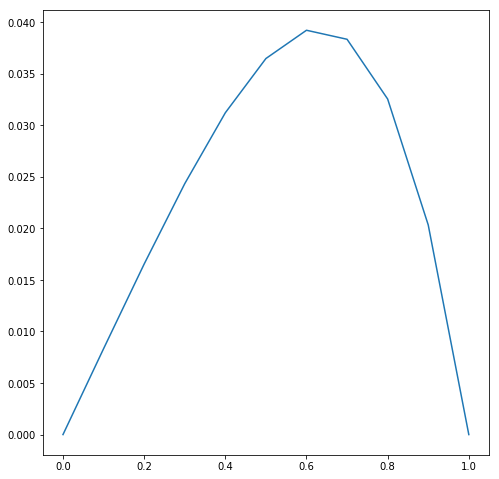

In [11]:
# Build a mesh on the fly and plot my u_h

mesh1_1D = fn.UnitIntervalMesh(L1D[0])

fig = plt.figure(figsize=(8,18))
fig.clear()
fn.plot(mesh1_1D)
ax = plt.subplot(2,1,1)

u_plot = fn.plot(My1Du_h)

The cell below solves the same exact problem as above with the same exact discretization using FEniCS. Thanks, Troy -- much of this code was hacked directly from Notebook 4.

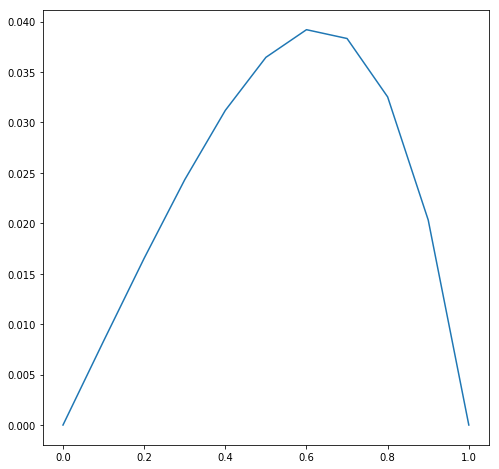

In [12]:
mesh1Ds = fn.UnitIntervalMesh(L1D[0]) # Computational mesh for approximation
V2 = fn.FunctionSpace(mesh1Ds, "Lagrange", 1) # Computational space for approximation

# Define Dirichlet boundary (x = 0, x = 1)
def boundary(x):
    return x[0] < fn.DOLFIN_EPS or x[0] > 1.0 - fn.DOLFIN_EPS

# Define boundary condition
u0 = fn.Constant(0.0)
bc = fn.DirichletBC(V2, u0, boundary)

# Define variational problem
u = fn.TrialFunction(V2)
v = fn.TestFunction(V2)
f = fn.Expression("(x[0])*(x[0])", degree=4)
a = fn.inner(fn.grad(u), fn.grad(v))*fn.dx
L = f*v*fn.dx

# Compute solution
u_FEM = fn.Function(V2)
fn.solve(a == L, u_FEM, bc)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(2,1,1)
fig.clear()

fenics_plot = fn.plot(u_FEM)

We have identical plots, which is a good sign! Now let's actually print out the stiffness matrix, $A$, and load vector ,$\mathbf{F}$, that FEniCS created for comparison to mine.

In [13]:
A,b = fn.assemble_system(a,L,bc)

print(A.array(), '=FEniCS A')

print()

print(My1DA, '= my A')

print()

print(np.transpose([b.get_local()]), '= FEniCS loading vector F')

print()

print(My1DF, '=my loading vector F')

print()

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -10.  20.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]] =FEniCS A

[[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   

We see mostly identical entries with a few key differences. Notice that the FEniCS $A$ has a ring of $0$'s and $1$'s on the edge that my $A$ does not -- this is because FEniCS does not know that the basis elements up against the boundary will be zeroed out by our BC's; their corresponding coefficients will be 0 in the solution $\mathbf{U}$. Ineed, we see matching $0$'s on the top and bottom of the FEniCS loading vector. Finally, the FEniCS loading vector is exactly the reverse of mine. This is due to FEniCS native indexing.

#### 2D Case (Numerical Testing)


We now verify that we have computed $A$ and $\mathbf{F}$ correctly by forming a numerical solution to compare to FEniCS.

In [14]:
# Grab the discretization parameters for meshes
n = L2D[0]
m = L2D[1]

# Create mesh for checking things in a minute...
mesh1 = fn.UnitSquareMesh(n, m, 'right') # Reference mesh

In [15]:
print('We must solve AU=F for U, where')

print()

print(My2DA,'=A')

print('and')
      
print(My2DF,'=F')

We must solve AU=F for U, where

[[ 4. -1.  0. -1.]
 [-1.  4. -1.  0.]
 [ 0. -1.  4. -1.]
 [-1.  0. -1.  4.]] =A
and
[[0.00233196]
 [0.00759031]
 [0.00759031]
 [0.02565158]] =F


We call the canned numpy matrix inverse command to solve for $\mathbf{U}=A^{-1}\mathbf{F}.$

In [16]:
My2DU=np.dot(np.linalg.inv(My2DA),My2DF)

print(My2DU)

[[0.00376658]
 [0.00410951]
 [0.00508116]
 [0.00862483]]


Now, since MyF returns the basis functions $\phi_i$, we can actually create $u_h=U_1\phi_1 + \cdots + U_N\phi_N.$

In [17]:
My2Du_h = My2DU[0][0]*My2DPHI[0]

for i in range(1,(n-1)*(m-1)):
    My2Du_h = My2Du_h + My2DU[i][0]*My2DPHI[i]

We can now plot our 2D $u_h$. Note that there are some strange undefined regions in the top left and bottom right elements. I have not been able to de-bug this! 

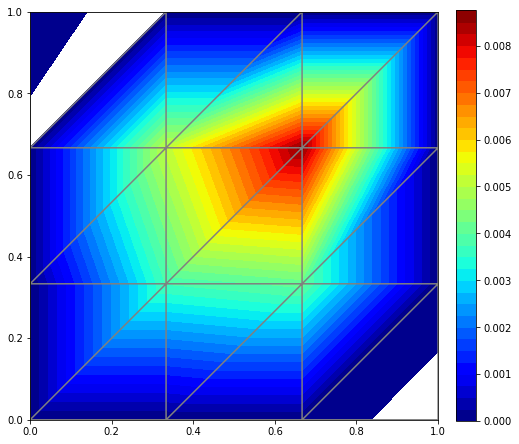

In [18]:
fig = plt.figure(figsize=(8,8))
fig.clear()
fn.plot(mesh1)

u_plot = fn.plot(My2Du_h)
u_plot.set_cmap("jet")
plt.colorbar(u_plot,fraction=0.046, pad=0.04)

Again, thanks Troy -- I was able to copy over Notebook 4 code to create a solution to the same exact 2D problem above using the same discretization using FEniCS below:

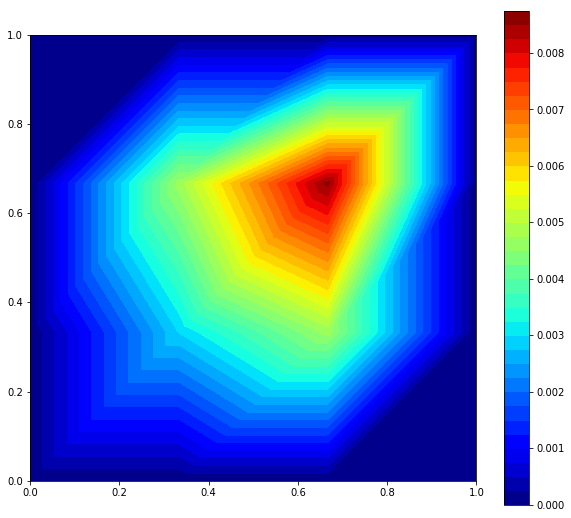

In [19]:
mesh2 = fn.UnitSquareMesh(n, m, 'right') # Computational mesh for approximation
V2 = fn.FunctionSpace(mesh2, "Lagrange", 1) # Computational space for approximation

# Define Dirichlet boundary (x = 0, x = 1, y=0 or y=1)
def boundary(x):
    return x[0] < fn.DOLFIN_EPS or x[0] > 1.0 - fn.DOLFIN_EPS \
           or x[1] < fn.DOLFIN_EPS or x[1] > 1.0 - fn.DOLFIN_EPS

# Define boundary condition
u0 = fn.Constant(0.0)
bc = fn.DirichletBC(V2, u0, boundary)

# Define variational problem
u = fn.TrialFunction(V2)
v = fn.TestFunction(V2)
f = fn.Expression("(x[0]*x[1])*(x[0]*x[1])", degree=4)
a = fn.inner(fn.grad(u), fn.grad(v))*fn.dx
L = f*v*fn.dx

# Compute solution
u_FEM = fn.Function(V2)
fn.solve(a == L, u_FEM, bc)

fig = plt.figure(figsize=(10,20))
fig.clear()
ax = plt.subplot(2,1,1)
fenics_plot = fn.plot(u_FEM)

fenics_plot.set_cmap("jet")
plt.colorbar(u_plot)

Again, we have very similar plots! Let's take a look at the matrices and loadings again.

In [20]:
A,b = fn.assemble_system(a,L,bc)

print(A.array(),'=FEniCS A')

print()

print(My2DA, '=my A')

print()

print(np.transpose([b.get_local()]), '=FEniCS loading F')

print()

print(My2DF, '=my loading F')

print()



[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  4.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  4.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3. 

As expected, the $A$ and $\mathbf{F}$ I created are permutations of the ones FEniCS gives. But there's clearly more going on with $A$. Notice that similarly to 1D, FEniCS is trying to fit interpolants that will eventually be zeroed out. In 1D, we used the zeros in the loading vector as a roadmap to find the useless entries in $A$. By deleting any column/row corresponding to a zero-valued $\mathbf{F}_i$, we will recover my $A$, up to a permutation.

We show this below, but only in the specific example I provide in this Notebook.

##### NOTE: The cell below will only work if L2D=[3,3] EXACTLY!

In [21]:
# Try to slice FEniCS matrix
# and make it look like ours

P=A.array()[:,4]
P=np.vstack((P,A.array()[:,7]))
P=np.vstack((P,A.array()[:,8]))
P=np.vstack((P,A.array()[:,11]))
P=P[:,4:]
P=P[:,0:8]

Q=np.vstack((P[:,0],P[:,3]))
Q=np.vstack((Q,P[:,4]))
Q=np.vstack((Q,P[:,7]))
print(Q, 'a permutation of my A above')

[[ 4. -1. -1.  0.]
 [-1.  4.  0. -1.]
 [-1.  0.  4. -1.]
 [ 0. -1. -1.  4.]] a permutation of my A above
